## Emotion Detection ##

**importing required libraries **

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image


In [2]:
import tensorflow as tf 
print("tensorflow version:",tf.__version__)

tensorflow version: 2.12.0


**Exploring dataset**

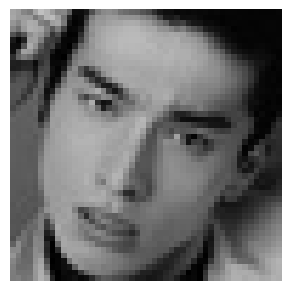

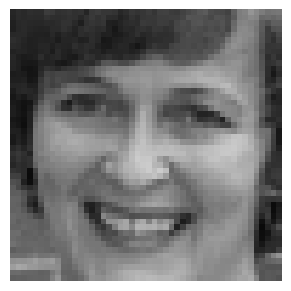

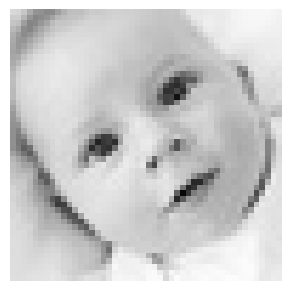

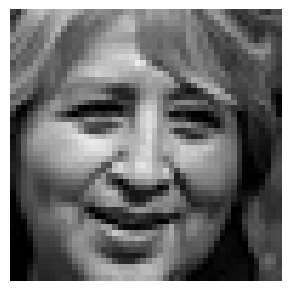

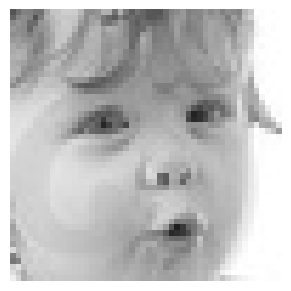

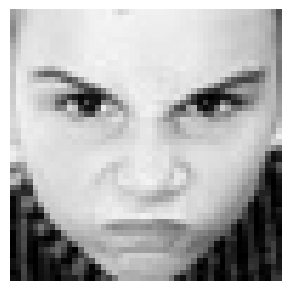

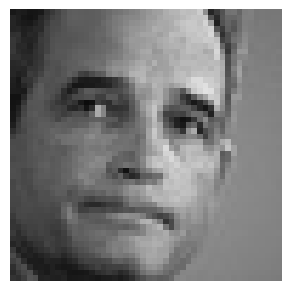

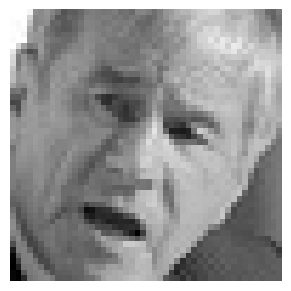

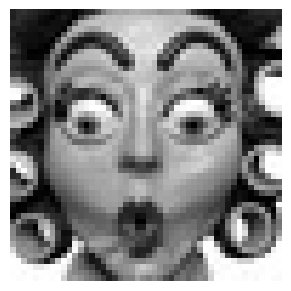

In [3]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**Preparing data for Training**

In [4]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",target_size=(img_size,img_size),color_mode='grayscale',
                                                   batch_size=batch_size,class_mode='categorical',shuffle=True)
datagen_validation = ImageDataGenerator()
validation_generator = datagen_validation.flow_from_directory("test/",target_size=(img_size,img_size),color_mode='grayscale',
                                                   batch_size=batch_size,class_mode='categorical',shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining the Model**

In [5]:
def convolution(input_tensor,filters,kernel_size):
    x = Conv2D(filters=filters,kernel_size=kernel_size,padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    return x

In [6]:
def dense(input_tensor,nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

In [7]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = convolution(inputs,32,(3,3))
    conv_2 = convolution(conv_1,64,(3,3))
    conv_3 = convolution(conv_2,128,(3,3))
    
    flatten = Flatten()(conv_3)
    dense_1 = dense(flatten,256)
    output = Dense(7,activation='softmax')(dense_1)
    
    model = Model(inputs=[inputs],outputs=[output])
    model.compile(loss=['categorical_crossentropy'],optimizer='adam',metrics=['accuracy'])
    return model


In [8]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0     

**Initializing the model**

In [9]:
epochs = 15
steps_per_epochs = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint('model_weights.h5',monitor='val_accuracy',save_weight_only=True,mode='max',verbose=1)
callbacks = [checkpoint]


## Training The Model

In [10]:
history = model.fit(
x = train_generator,steps_per_epoch=steps_per_epochs,epochs=epochs,
    validation_data=validation_generator,validation_steps=validation_steps,
    callbacks=callbacks)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 1.6832 - accuracy: 0.3632
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 212s 470ms/step - loss: 1.6832 - accuracy: 0.3632 - val_loss: 1.6185 - val_accuracy: 0.3736
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.3974 - accuracy: 0.4646
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 107s 240ms/step - loss: 1.3974 - accuracy: 0.4646 - val_loss: 1.3095 - val_accuracy: 0.4996
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.2903 - accuracy: 0.5077
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 137s 305ms/step - loss: 1.2903 - accuracy: 0.5077 - val_loss: 1.4450 - val_accuracy: 0.4616
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.2186 - accuracy: 0.5381
Epoch 4: saving model to model_weights.h5
448/448 [==============================] - 

**model evaluation**

In [11]:
model.evaluate(validation_generator)

113/113 [==============================] - 5s 42ms/step - loss: 1.0851 - accuracy: 0.6052


[1.085079550743103, 0.6051825284957886]

**Plotting Loss**

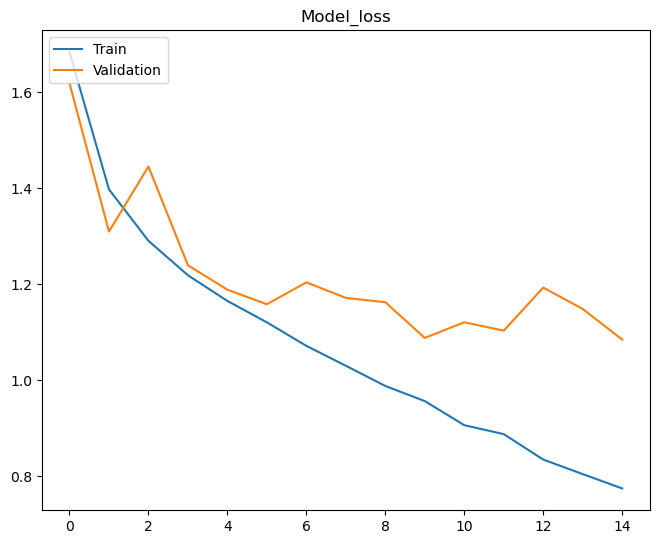

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss')
plt.legend(['Train','Validation'],loc='upper left',)
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)


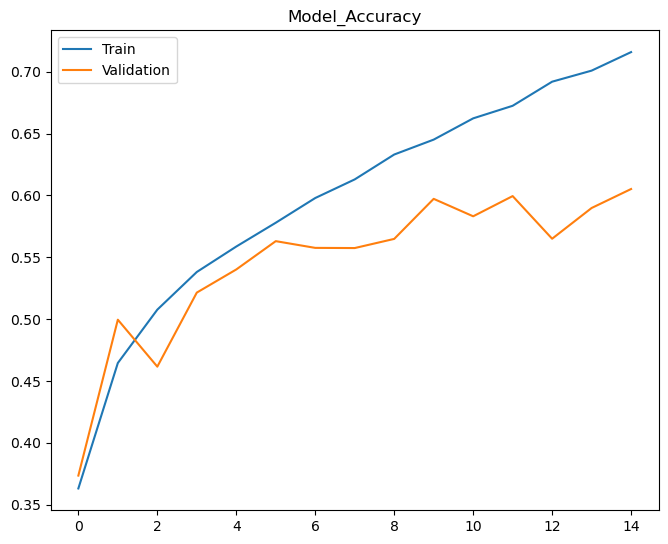

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_Accuracy')
plt.legend(['Train','Validation'],loc='upper left',)
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)


**Saving Model**

In [14]:
model_json = model.to_json()
with open('model_a1.json','w') as json_file:
    json_file.write(model_json)